# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

A subdirectory or file data already exists.


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

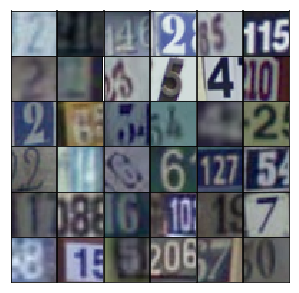

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [18]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [19]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [21]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [22]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [23]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [24]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.001
batch_size = 64
epochs = 1
alpha = 0.01
beta1 = 0.9

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/1... Discriminator Loss: 0.0672... Generator Loss: 2.7970
Epoch 1/1... Discriminator Loss: 0.0140... Generator Loss: 6.7470
Epoch 1/1... Discriminator Loss: 0.0525... Generator Loss: 3.7607
Epoch 1/1... Discriminator Loss: 0.0196... Generator Loss: 6.3813
Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 9.0356
Epoch 1/1... Discriminator Loss: 0.0026... Generator Loss: 6.3783
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 6.5875
Epoch 1/1... Discriminator Loss: 0.0063... Generator Loss: 5.2731
Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 5.6743
Epoch 1/1... Discriminator Loss: 0.0069... Generator Loss: 7.6081


c:\programdata\anaconda3\envs\aind\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


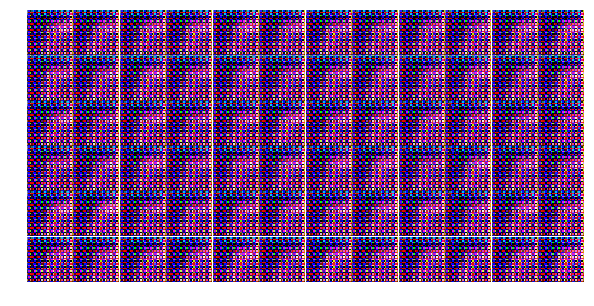

Epoch 1/1... Discriminator Loss: 0.0069... Generator Loss: 5.3248
Epoch 1/1... Discriminator Loss: 0.0354... Generator Loss: 7.4594
Epoch 1/1... Discriminator Loss: 0.1013... Generator Loss: 10.4519
Epoch 1/1... Discriminator Loss: 0.0406... Generator Loss: 5.4761
Epoch 1/1... Discriminator Loss: 0.0606... Generator Loss: 5.0469
Epoch 1/1... Discriminator Loss: 0.0478... Generator Loss: 4.4812
Epoch 1/1... Discriminator Loss: 0.0098... Generator Loss: 5.6501
Epoch 1/1... Discriminator Loss: 0.0150... Generator Loss: 5.2691
Epoch 1/1... Discriminator Loss: 0.1202... Generator Loss: 4.8540
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 9.1028


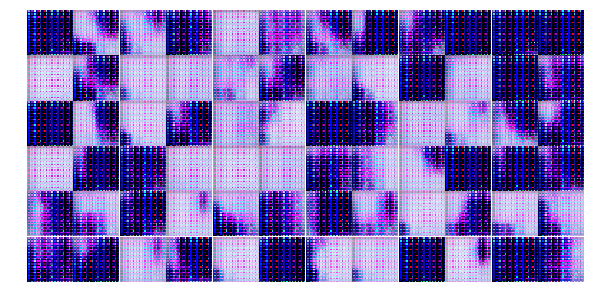

Epoch 1/1... Discriminator Loss: 0.0055... Generator Loss: 6.3637
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 8.1354
Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 5.4406
Epoch 1/1... Discriminator Loss: 0.0040... Generator Loss: 6.7691
Epoch 1/1... Discriminator Loss: 0.0124... Generator Loss: 5.8640
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 8.0468
Epoch 1/1... Discriminator Loss: 0.0118... Generator Loss: 9.4867
Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 9.8264
Epoch 1/1... Discriminator Loss: 0.0051... Generator Loss: 6.4149
Epoch 1/1... Discriminator Loss: 0.0510... Generator Loss: 4.3811


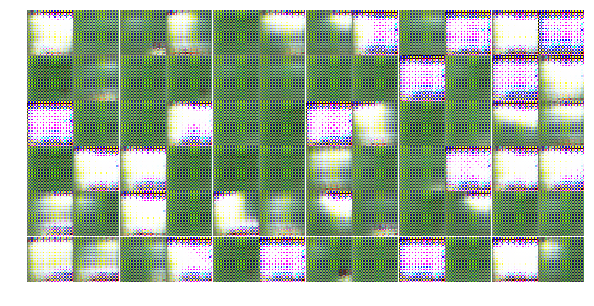

Epoch 1/1... Discriminator Loss: 0.0094... Generator Loss: 6.0260
Epoch 1/1... Discriminator Loss: 0.0289... Generator Loss: 7.0508
Epoch 1/1... Discriminator Loss: 0.0899... Generator Loss: 4.3947
Epoch 1/1... Discriminator Loss: 0.2471... Generator Loss: 3.4900
Epoch 1/1... Discriminator Loss: 0.0489... Generator Loss: 3.8401
Epoch 1/1... Discriminator Loss: 0.1136... Generator Loss: 3.0364
Epoch 1/1... Discriminator Loss: 1.7746... Generator Loss: 0.2153
Epoch 1/1... Discriminator Loss: 0.1328... Generator Loss: 4.0766
Epoch 1/1... Discriminator Loss: 0.0427... Generator Loss: 3.9215
Epoch 1/1... Discriminator Loss: 0.4267... Generator Loss: 1.6163


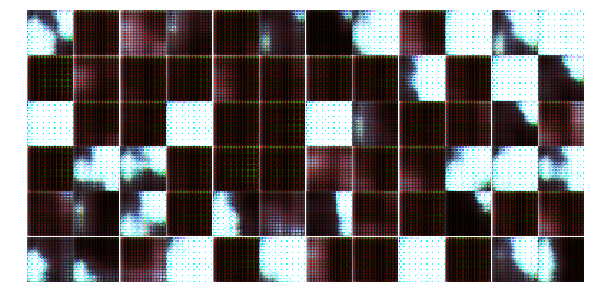

Epoch 1/1... Discriminator Loss: 0.1008... Generator Loss: 3.3011
Epoch 1/1... Discriminator Loss: 0.1465... Generator Loss: 5.6382
Epoch 1/1... Discriminator Loss: 0.0173... Generator Loss: 4.9978
Epoch 1/1... Discriminator Loss: 0.0178... Generator Loss: 6.0920
Epoch 1/1... Discriminator Loss: 0.2440... Generator Loss: 6.3025
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.4963
Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 7.1605
Epoch 1/1... Discriminator Loss: 0.0749... Generator Loss: 5.0878
Epoch 1/1... Discriminator Loss: 0.3934... Generator Loss: 2.4107
Epoch 1/1... Discriminator Loss: 0.1217... Generator Loss: 4.7581


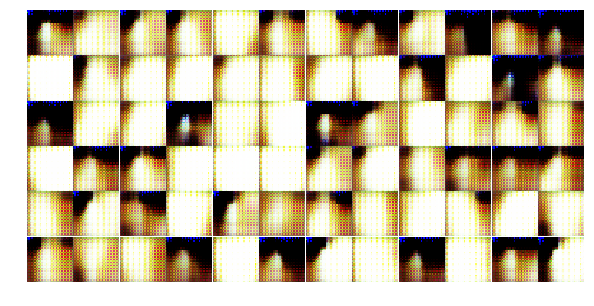

Epoch 1/1... Discriminator Loss: 0.0953... Generator Loss: 4.1550
Epoch 1/1... Discriminator Loss: 0.0912... Generator Loss: 6.5557
Epoch 1/1... Discriminator Loss: 0.1408... Generator Loss: 6.2836
Epoch 1/1... Discriminator Loss: 0.0755... Generator Loss: 5.6499
Epoch 1/1... Discriminator Loss: 0.0081... Generator Loss: 6.0107
Epoch 1/1... Discriminator Loss: 0.0344... Generator Loss: 4.2361
Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 6.3847
Epoch 1/1... Discriminator Loss: 0.0023... Generator Loss: 6.6854
Epoch 1/1... Discriminator Loss: 0.1718... Generator Loss: 12.2930
Epoch 1/1... Discriminator Loss: 0.2596... Generator Loss: 6.2303


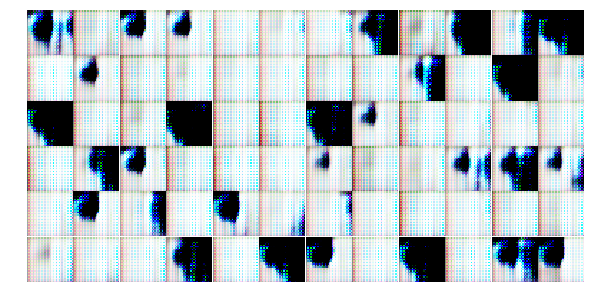

Epoch 1/1... Discriminator Loss: 0.0455... Generator Loss: 7.0796
Epoch 1/1... Discriminator Loss: 0.0493... Generator Loss: 4.1835
Epoch 1/1... Discriminator Loss: 0.0140... Generator Loss: 8.2811
Epoch 1/1... Discriminator Loss: 0.0631... Generator Loss: 5.0187
Epoch 1/1... Discriminator Loss: 0.0816... Generator Loss: 9.4517
Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 16.7384
Epoch 1/1... Discriminator Loss: 0.0141... Generator Loss: 7.3662
Epoch 1/1... Discriminator Loss: 0.1728... Generator Loss: 5.9928
Epoch 1/1... Discriminator Loss: 0.1861... Generator Loss: 5.6878
Epoch 1/1... Discriminator Loss: 0.6360... Generator Loss: 2.0787


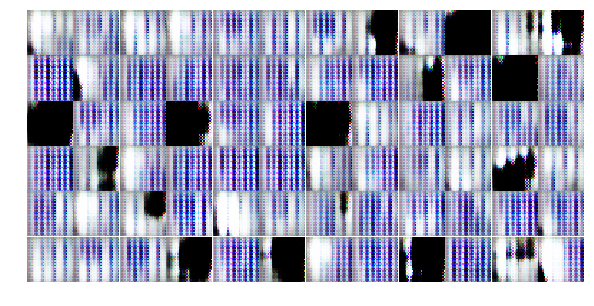

Epoch 1/1... Discriminator Loss: 0.1338... Generator Loss: 9.0807
Epoch 1/1... Discriminator Loss: 0.1453... Generator Loss: 3.9434
Epoch 1/1... Discriminator Loss: 0.0510... Generator Loss: 8.2656
Epoch 1/1... Discriminator Loss: 0.0275... Generator Loss: 7.2538
Epoch 1/1... Discriminator Loss: 0.0296... Generator Loss: 10.2738
Epoch 1/1... Discriminator Loss: 0.0637... Generator Loss: 6.6386
Epoch 1/1... Discriminator Loss: 0.4275... Generator Loss: 2.5056
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 1.2962
Epoch 1/1... Discriminator Loss: 0.1019... Generator Loss: 4.5490
Epoch 1/1... Discriminator Loss: 0.1727... Generator Loss: 5.3930


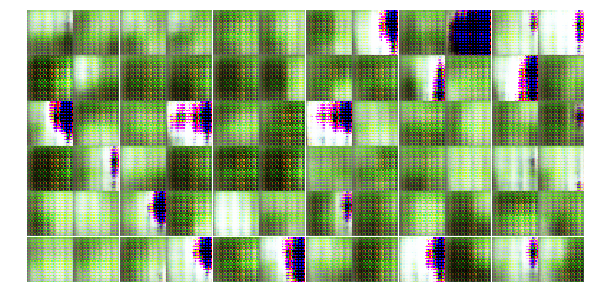

Epoch 1/1... Discriminator Loss: 0.1347... Generator Loss: 3.2377
Epoch 1/1... Discriminator Loss: 0.2024... Generator Loss: 2.3105
Epoch 1/1... Discriminator Loss: 0.0870... Generator Loss: 4.0053
Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 1.2535
Epoch 1/1... Discriminator Loss: 0.1582... Generator Loss: 8.7833
Epoch 1/1... Discriminator Loss: 0.1367... Generator Loss: 4.3220
Epoch 1/1... Discriminator Loss: 0.2189... Generator Loss: 2.8847
Epoch 1/1... Discriminator Loss: 0.0227... Generator Loss: 11.7673
Epoch 1/1... Discriminator Loss: 0.1950... Generator Loss: 3.0641
Epoch 1/1... Discriminator Loss: 1.6721... Generator Loss: 7.6834


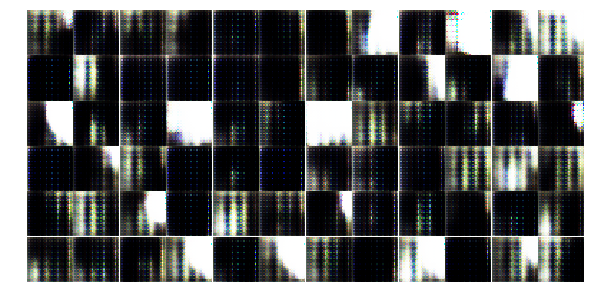

Epoch 1/1... Discriminator Loss: 0.1198... Generator Loss: 4.4409
Epoch 1/1... Discriminator Loss: 0.2371... Generator Loss: 2.5389
Epoch 1/1... Discriminator Loss: 0.2518... Generator Loss: 1.8898
Epoch 1/1... Discriminator Loss: 0.0153... Generator Loss: 5.9879
Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 5.6846
Epoch 1/1... Discriminator Loss: 0.2835... Generator Loss: 2.3013
Epoch 1/1... Discriminator Loss: 0.1538... Generator Loss: 4.0308
Epoch 1/1... Discriminator Loss: 0.1402... Generator Loss: 5.5285
Epoch 1/1... Discriminator Loss: 0.0316... Generator Loss: 6.0213
Epoch 1/1... Discriminator Loss: 0.0439... Generator Loss: 4.7120


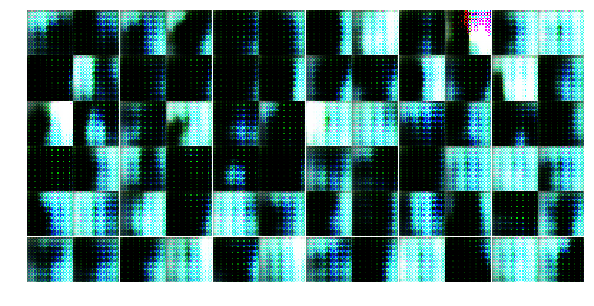

Epoch 1/1... Discriminator Loss: 0.0854... Generator Loss: 3.8733
Epoch 1/1... Discriminator Loss: 0.0278... Generator Loss: 5.0085
Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 8.0908
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 10.3142
Epoch 1/1... Discriminator Loss: 0.1599... Generator Loss: 9.9835
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 7.3285
Epoch 1/1... Discriminator Loss: 0.2945... Generator Loss: 2.6701
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 9.1194
Epoch 1/1... Discriminator Loss: 0.1961... Generator Loss: 3.9606
Epoch 1/1... Discriminator Loss: 0.3563... Generator Loss: 4.8367


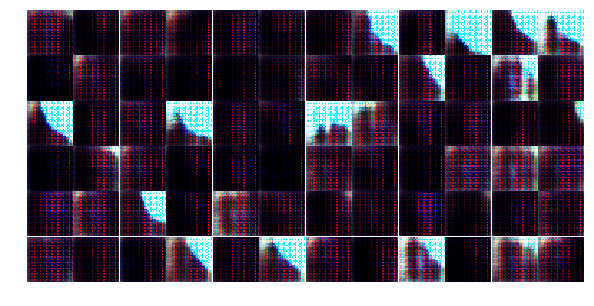

Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 5.3203
Epoch 1/1... Discriminator Loss: 0.0078... Generator Loss: 6.3837
Epoch 1/1... Discriminator Loss: 0.3124... Generator Loss: 6.7366
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 10.5354


In [25]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

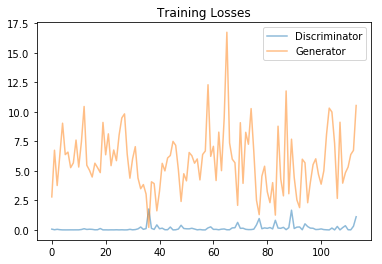

In [26]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

c:\programdata\anaconda3\envs\aind\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


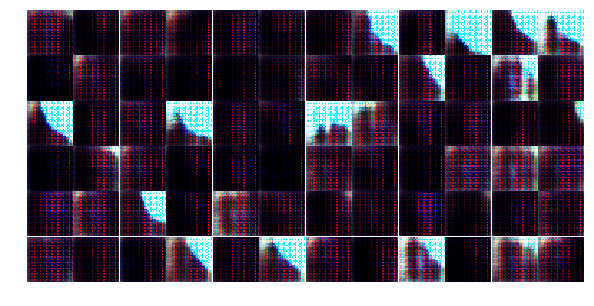

In [27]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))